# Measuring spatial distribution

Spatial distribution can be captured many ways. This notebook show couple of them, based on orientation and street corridor.

In [1]:
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
import osmnx as ox

gdf = ox.footprints.footprints_from_place(place='Kahla, Germany')
gdf_projected = ox.projection.project_gdf(gdf)

buildings = momepy.preprocess(gdf_projected, size=30,
                              compactness=True, islands=True)
buildings['uID'] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)
tessellation = momepy.Tessellation(buildings, unique_id='uID', limit=limit).tessellation

Loop 1 out of 2.


Changing geometry: 100%|██████████| 31/31 [00:00<00:00, 90.11it/s]


Loop 2 out of 2.


Changing geometry: 100%|██████████| 2/2 [00:00<00:00, 49.35it/s]


Inward offset...
Discretization...


  2%|▏         | 40/2521 [00:00<00:06, 394.29it/s]

Generating input point array...


100%|██████████| 2521/2521 [00:03<00:00, 648.20it/s]


Generating Voronoi diagram...
Generating GeoDataFrame...


Vertices to Polygons: 100%|██████████| 267595/267595 [00:07<00:00, 37881.70it/s]


Dissolving Voronoi polygons...
Preparing limit for edge resolving...
Building R-tree...
Identifying edge cells...


 11%|█         | 26/238 [00:00<00:00, 255.17it/s]

Cutting...


100%|██████████| 238/238 [00:00<00:00, 443.19it/s]


In [3]:
streets_graph = ox.graph_from_place('Kahla, Germany', network_type='drive')
streets_graph = ox.projection.project_graph(streets_graph)
edges = ox.graph_to_gdfs(streets_graph, nodes=False, edges=True,
                                   node_geometry=False, fill_edge_geometry=True)

## Alignment

We can measure alignment of different elements to their neighbours (for which `spatial_weights` are needed) or to different elements. We will explore cell alignment (difference of orientation of buildings and cells) and street alignment (difference of orientation of buildings and street segments).

### Cell alignment

For `CellAlignment` we need to know orientations, so let's calculate them first. Orientation is defined as an orientation of the longext axis of bounding rectangle in range [0,45). It captures the deviation of orientation from cardinal directions:

In [4]:
buildings['orientation'] = momepy.Orientation(buildings).series
tessellation['orientation'] = momepy.Orientation(tessellation).series

100%|██████████| 2518/2518 [00:11<00:00, 217.18it/s]


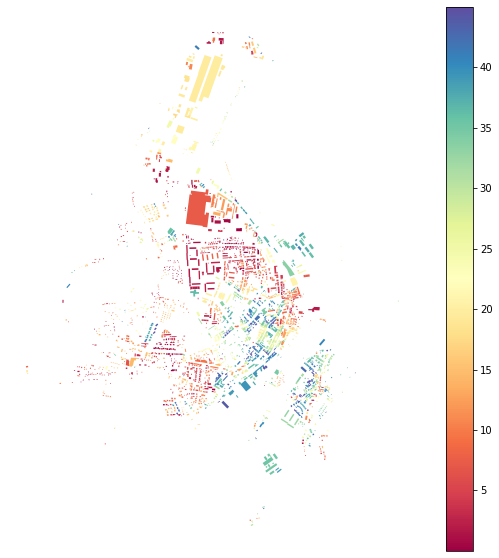

In [5]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='orientation', legend=True, cmap='Spectral')
ax.set_axis_off()
plt.show()

`CellAlignment` requires both gdfs, orientation values for left and right gdf and unique ID linking both gdfs as is in left and right gdf:

In [6]:
blg_cell_align = momepy.CellAlignment(buildings, tessellation,
                                      'orientation', 'orientation',
                                      'uID', 'uID')
buildings['cell_align'] = blg_cell_align.series

100%|██████████| 2518/2518 [00:03<00:00, 698.54it/s]


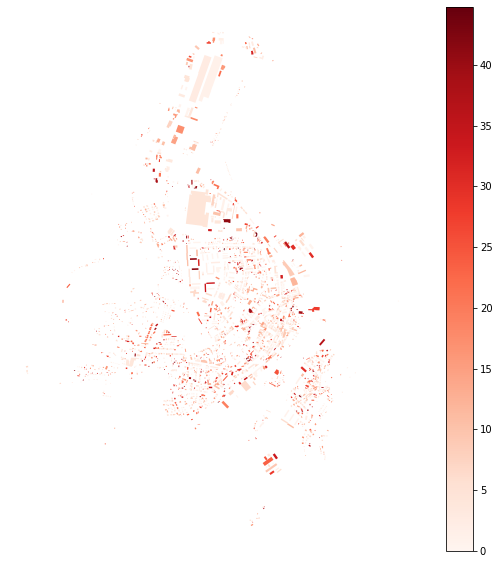

In [7]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='cell_align', legend=True, cmap='Reds')
ax.set_axis_off()
plt.show()

No really clear pattern is visible in this case, but it might be in other, especially comparing building orientation with plots.

### Street alignment

Street alignment works on the same principle as cell alignment. What we do not have at this moment is network ID, so we have to generate it and link it to buildings:

In [5]:
edges['networkID'] = momepy.unique_id(edges)
buildings['networkID'] = momepy.get_network_id(buildings, edges,
                                               'networkID')

Snapping:   4%|▍         | 110/2518 [00:00<00:02, 1089.94it/s]

Generating centroids...
Generating rtree...


Snapping: 100%|██████████| 2518/2518 [00:02<00:00, 1046.46it/s]
/Users/martin/Strathcloud/Personal Folders/momepy/momepy/momepy/elements.py:724: UserWarning: Some objects were not attached to the network. Set larger min_size. 240 affected elements
  "Set larger min_size. {} affected elements".format(sum(series.isnull()))


**Note**: UserWarning tells us, that not all buildings were linked to the network. Keep in mind that it may cause issues with missing values later.

OSM network is not ideal in our case, it is missing in part of the study area. Some objects were not attached to the network with `min_size` defaulting to 100 metres. We can either use larger distance or drop unlinked buildings. 

In [6]:
buildings_net = buildings.loc[buildings.networkID >= 0]

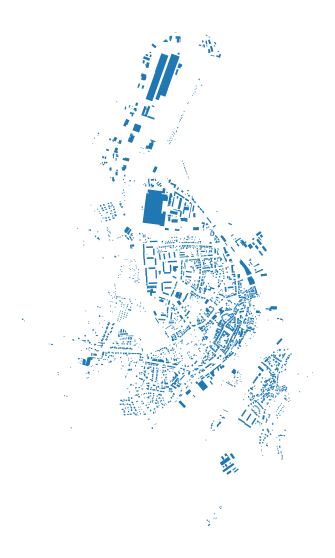

In [10]:
f, ax = plt.subplots(figsize=(10, 10))
buildings_net.plot(ax=ax)
ax.set_axis_off()
plt.show()

`StreetAlignment` will take care of street orientation (saved under `orientations` attribute):

In [7]:
str_align = momepy.StreetAlignment(buildings_net, edges,
                                   'orientation', 'networkID',
                                   'networkID')
buildings_net['str_align'] = str_align.series

100%|██████████| 2276/2276 [00:05<00:00, 389.41it/s]
/Users/martin/anaconda3/envs/momepy_guide/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


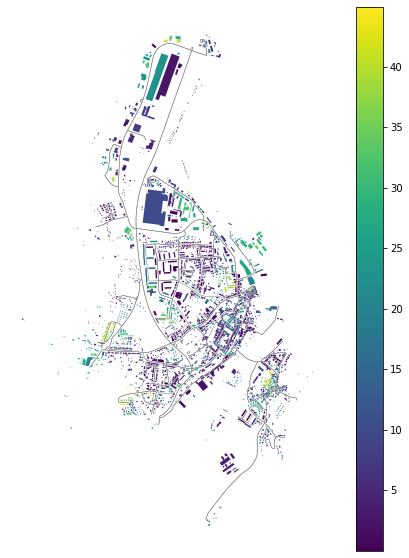

In [12]:
f, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, color='grey', linewidth=0.5)
buildings_net.plot(ax=ax, column='str_align', legend=True)
ax.set_axis_off()
plt.show()

## Street profile

`StreetProfile` captures several characters at the same time. It generates a series of perpendicular ticks of set length and set spacing and returns mean widths of street profile, their standard deviation, mean height and its standard deviation, profile as a ratio of widht and height and degree of openness. If heights are not passed, it will not return them and profile. We will use Manhattan example to illustrate how it works. Building `height` column is converted to float and buildings are exploded to avoid multipolygons.

In [13]:
point = (40.731603, -73.977857)
dist = 1000
gdf = ox.footprints.footprints_from_point(point, dist)
buildings = ox.projection.project_gdf(gdf)
buildings['height'] = buildings['height'].fillna(0).astype(float)
buildings = buildings.explode()
buildings.reset_index(inplace=True, drop=True)

In [14]:
streets_graph = ox.graph_from_point(point, dist, network_type='drive')
streets_graph = ox.projection.project_graph(streets_graph)
edges = ox.graph_to_gdfs(streets_graph, nodes=False, edges=True,
                                   node_geometry=False, fill_edge_geometry=True)

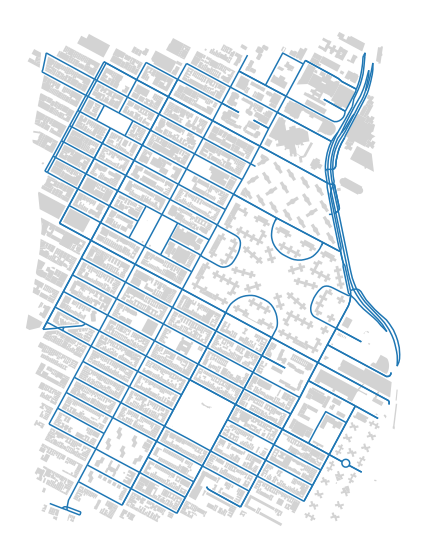

In [15]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, color='lightgrey')
edges.plot(ax=ax)
ax.set_axis_off()
plt.show()

In [16]:
profile = momepy.StreetProfile(edges, buildings, heights='height')

100%|██████████| 431/431 [00:55<00:00,  7.82it/s]


We can assign measrued characters as columns of edges gdf:

In [17]:
edges['widths'] = profile.w
edges['width_deviations'] = profile.wd
edges['openness'] = profile.o
edges['heights'] = profile.h
edges['heights_deviations'] = profile.hd
edges['profile'] = profile.p

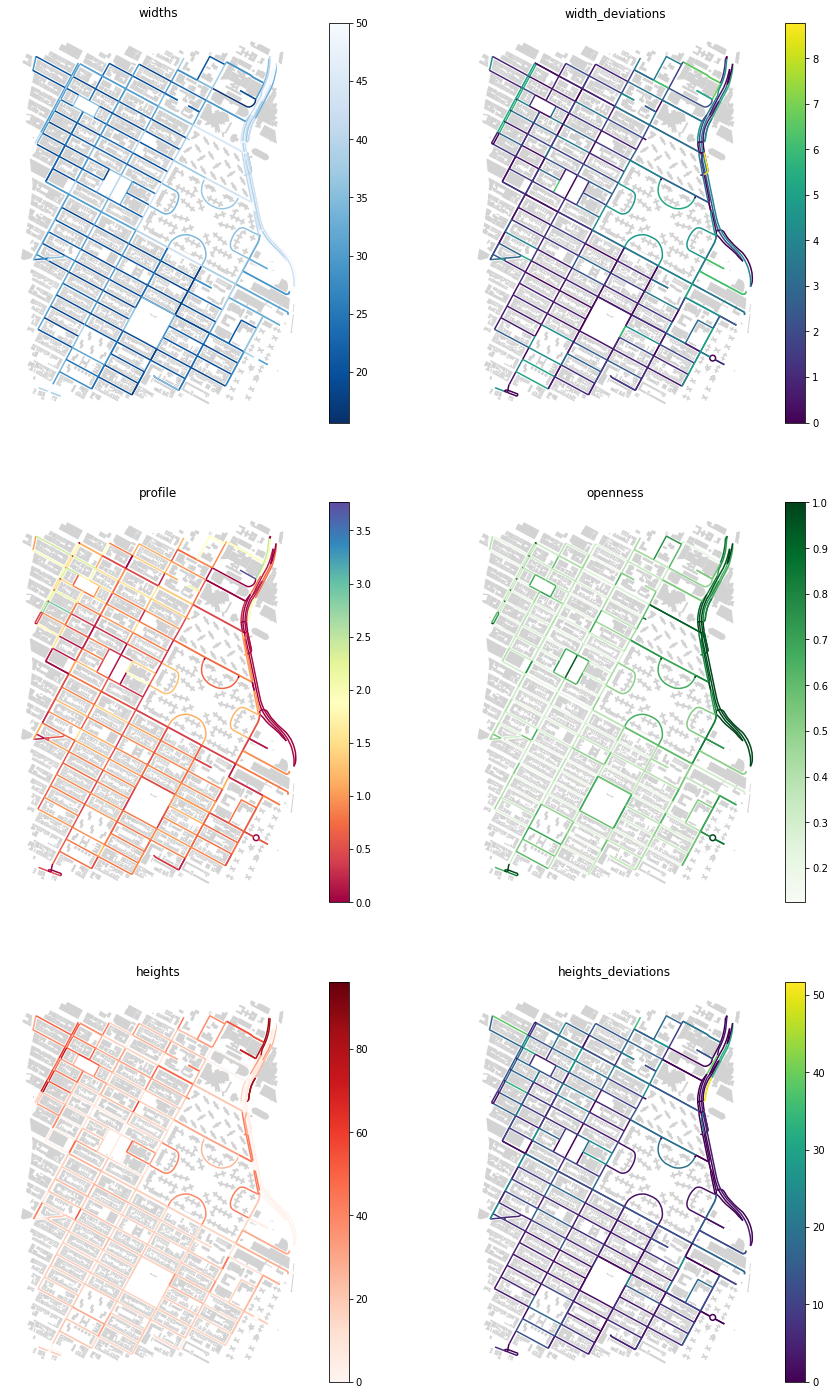

In [18]:
f, axes = plt.subplots(figsize=(15, 25), ncols=2, nrows=3)
edges.plot(ax=axes[0][0], column='widths', legend=True, cmap='Blues_r')
buildings.plot(ax=axes[0][0], color='lightgrey')
edges.plot(ax=axes[0][1], column='width_deviations', legend=True)
buildings.plot(ax=axes[0][1], color='lightgrey')
axes[0][0].set_axis_off()
axes[0][0].set_title('widths')
axes[0][1].set_axis_off()
axes[0][1].set_title('width_deviations')
edges.plot(ax=axes[1][0], column='profile', legend=True, cmap='Spectral')
buildings.plot(ax=axes[1][0], color='lightgrey')
edges.plot(ax=axes[1][1], column='openness', legend=True, cmap='Greens')
buildings.plot(ax=axes[1][1], color='lightgrey')
axes[1][0].set_axis_off()
axes[1][0].set_title('profile')
axes[1][1].set_axis_off()
axes[1][1].set_title('openness')
edges.plot(ax=axes[2][0], column='heights', legend=True, cmap='Reds')
buildings.plot(ax=axes[2][0], color='lightgrey')
edges.plot(ax=axes[2][1], column='heights_deviations', legend=True)
buildings.plot(ax=axes[2][1], color='lightgrey')
axes[2][0].set_axis_off()
axes[2][0].set_title('heights')
axes[2][1].set_axis_off()
axes[2][1].set_title('heights_deviations')
plt.show()